# Notebook for preprocessing the LOFAR catalogues before XID+

it outputs a modified LOFAR radio data table with two new columns. the first column is XID+_rerun and is a boolean array stating whether a source should ahve XID+ rerun or not. The second is a string column that says what where the fir for that source comes from.

In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os
import pymoc
import mocpy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
#from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
#from herschelhelp_internal.utils import inMoc
from pymoc.io.fits import read_moc_fits



In [2]:
def best_irac(swire,servs):
    mask = np.isnan(swire)
    swire[mask] = 10000
    mask = np.isnan(servs)
    servs[mask] = 10000
    swire_mask = swire<servs
    return(swire_mask)

In [6]:
lofar = Table.read('data/LH_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_public.fits')

mask = ~np.isnan(lofar['F_SPIRE_250'])
c = SkyCoord(lofar['RA'][mask],lofar['DEC'][mask],unit='deg')
#spire_moc = pymoc.util.catalog.catalog_to_moc(c,15,12)
spire_moc = pymoc.moc.MOC()
read_moc_fits(spire_moc,'/lustre/scratch/astro/im281/HELP/dmu_products/dmu2/dmu2_field_coverages/Lockman-SWIRE_MOC.fits')
print('SPIRE covers: {}sq degrees'.format(spire_moc.area_sq_deg))

mask = ~np.isnan(lofar['F_PACS_100'])
c = SkyCoord(lofar['RA'][mask],lofar['DEC'][mask],unit='deg')
pacs_moc = pymoc.util.catalog.catalog_to_moc(c,15,12)
print('PACS covers: {}sq degrees'.format(pacs_moc.area_sq_deg))

mask = ~np.isnan(lofar['F_MIPS_24'])
c = SkyCoord(lofar['RA'][mask],lofar['DEC'][mask],unit='deg')
mips_moc = pymoc.util.catalog.catalog_to_moc(c,15,12)
print('MIPS covers: {}sq degrees'.format(mips_moc.area_sq_deg))

SPIRE covers: 22.413863402949218sq degrees
PACS covers: 10.331753949911489sq degrees
MIPS covers: 10.794021152937951sq degrees


In [3]:
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/Lockman-SWIRE/data/'

pswfits=imfolder+'wp4_lockman-swire_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header
mips_moc = mocpy.MOC.from_image(im250hdu,15)

mips_moc.write('data/data_release/final_mocs/mips_moc_Lockman.fits',format='fits',overwrite=True)

mips_moc = pymoc.moc.MOC()
read_moc_fits(mips_moc,'data/data_release/final_mocs/mips_moc_Lockman.fits')
print('MIPS covers: {}sq degrees'.format(mips_moc.area_sq_deg))

MIPS covers: 17.977005601837728sq degrees


In [5]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_HELP-PACS-maps/data/'

im100fits=imfolder + 'Lockman-SWIRE_PACS100_v0.9.fits'#PACS 100 map
#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[1].header
pacs_moc = mocpy.MOC.from_image(im100hdu,15)

pacs_moc.write('data/data_release/final_mocs/pacs_moc_Lockman.fits',format='fits',overwrite=True)

pacs_moc = pymoc.moc.MOC()
read_moc_fits(pacs_moc,'data/data_release/final_mocs/pacs_moc_Lockman.fits')
print('PACS covers: {}sq degrees'.format(pacs_moc.area_sq_deg))

PACS covers: 32.20707401227812sq degrees


In [6]:
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'

pswfits=imfolder+'Lockman-SWIRE_SPIRE250_v1.0.fits'#SPIRE 250 map

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header
spire_moc = mocpy.MOC.from_image(im250hdu,15)

spire_moc.write('data/data_release/final_mocs/spire_moc_Lockman.fits',format='fits',overwrite=True)

spire_moc = pymoc.moc.MOC()
read_moc_fits(spire_moc,'data/data_release/final_mocs/spire_moc_Lockman.fits')
print('SPIRE covers: {}sq degrees'.format(spire_moc.area_sq_deg))

SPIRE covers: 36.20155006580141sq degrees


## Read in the LOFAR catalogues and work out which sources need to be rerun 

In [4]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]
print(len(lofar))

ras = lofar['optRA']
mask = np.isnan(ras)
print(np.sum(mask))
ras[mask] = lofar['RA'][mask]

decs = lofar['optDec']
mask = np.isnan(decs)
print(np.sum(mask))
decs[mask] = lofar['DEC'][mask]

ids = lofar['Source_Name']

11757
768
768


In [5]:
cra = Column(ras,name='ra')
cdec = Column(decs,name='dec')
cids = Column(ids,name='help_id')
cdet = Column(np.zeros(len(ras))-99,name='flag_optnir_det')
cmips = Column(np.zeros(len(ras))*np.nan,name='f_mips_24')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,cmips])

## Read in the HELP masterlist

In [6]:
columns = 'ra','dec','help_id','flag_optnir_det','f_irac_i1','f_irac_i2','f_irac_i3','f_irac_i4','f_mips_24','f_pacs_green','f_spire_250'
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')
help_masterlist = masterlist[columns]
help_masterlist[0]

ra,dec,help_id,flag_optnir_det,f_irac_i1,f_irac_i2,f_irac_i3,f_irac_i4,f_mips_24,f_pacs_green,f_spire_250
deg,deg,,,,,uJy,uJy,uJy,mJy,mJy
float64,float64,bytes33,int64,float64,float64,float64,float64,float32,float32,float32
155.7719884600245,59.036624215749754,HELP_J102305.277+590211.847,1,nan,nan,nan,nan,nan,nan,nan


## Create the prior catalogue using the MIPS priors

In [21]:
mips_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)

prior_cat = help_masterlist[mips_mask]
print('number of help prior sources is: {}'.format(len(prior_cat)))

number of help prior sources is: 249732


In [22]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

261489

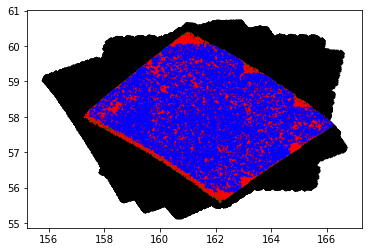

In [23]:
x = help_masterlist['ra']
y = help_masterlist['dec']
plt.scatter(x,y,s=0.1,c='black')

mips_mask = (help_masterlist['flag_optnir_det']>=5)
x = help_masterlist['ra'][mips_mask]
y = help_masterlist['dec'][mips_mask]
plt.scatter(x,y,s=0.1,c='green')

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1,c='red')


plt.scatter(ras,decs,s=1,c='blue')

plt.show()

In [24]:
#Table.write(prior_cat,'data/data_release/xidplus_prior_cat_rerun_mips.fits',overwrite=True)

from astropy.io import registry
from astropy.table.info import serialize_method_as

with serialize_method_as(prior_cat, None):
            registry.write(prior_cat,'data/data_release/xidplus_prior_cat_rerun_mips.fits',overwrite=True,format='fits')

<class 'astropy.table.table.Table'>
fits


## Create the prior catalogue using the Ldust priors

In [10]:
ldust = Table.read('../../../../../HELP/dmu_products/dmu28/dmu28_Lockman-SWIRE/data/Lockman-SWIRE_Ldust_prediction_results.fits')
ldust.rename_column('id','help_id')
for n in range(len(ldust)):
    ldust[n]['help_id']=ldust[n]['help_id'].replace(' ','')

In [11]:
ldust_coords = join(ldust,help_masterlist,keys='help_id',join_type='left')

In [12]:
ldust_coords[0]

help_id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,best.chi_square,best.reduced_chi_square,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.wfc_u,best.megacam_u,best.megacam_g,best.gpc1_g,best.wfc_g,best.gpc1_r,best.wfc_r,best.megacam_r,best.gpc1_i,best.megacam_i,best.megacam_y,best.wfc_i,best.gpc1_z,best.wfc_z,best.megacam_z,best.gpc1_y,best.ukidss_j,best.ukidss_k,best.irac_i1,best.irac_i2,best.irac_i3,best.irac_i4,best.mips_24,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500,ra,dec,flag_optnir_det,f_irac_i1,f_irac_i2,f_irac_i3,f_irac_i4,f_mips_24,f_pacs_green,f_spire_250
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,deg,deg,,,,uJy,uJy,uJy,mJy,mJy
bytes33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float32,float32,float32
HELP_J103755.490+592806.025,5604412346.505531,1070659840.429403,5.845980012139975,6.010488895730351,2.003748523970805e+37,1.3759500905290382e+37,75.78360855764737,18.945902139411842,2.8,0.5,1.896233573947713,4.491140701590342,-0.7,-0.7,1.1367687579411335e+37,1.2326699066642044e+37,2.0,0.02,2.369438664605338e+37,1.2937072401026876e+38,0.47,5.0,0.0,0.0,2500.0,10.0,0.001,9158179043.325256,6.351138944998894,5.507923162086263,6.349904297712362,10000.0,3000.0,907.548715023767,1.0,2.58301271179141e+36,1.355117639488918e+34,2.569461535396521e+36,3402142331.604237,3398017545.981012,4124785.6232251436,5756036668.891398,5696662454.367122,59374214.52427643,0.02,7.909108234720333e+53,4.06161354487228e+51,7.86849209927161e+53,10.0,7527.949072306243,1.2775728113550273e+26,0.68,0.00022993478651882037,0.0002440554965314313,0.0004048585617593933,0.00040636627766923723,0.00040743933416579947,0.0008730861915721103,0.0008718679753063824,0.0008871033886155384,0.001870919806343346,0.001862288665271551,0.0019313356246307095,0.0019359142594710939,0.0023019628418220945,0.0023078902290584466,0.002390749080629269,0.002732844756374034,0.003823753093091422,0.006800458449608271,0.007565527949133713,0.005584428627091305,0.005121825268087085,0.005815289504854415,0.0568758741497294,2.045884151785734,4.039374641860336,3.738050847993529,2.20094672000906,0.9944247615450231,159.4812079600245,59.46834031574975,3,nan,nan,nan,nan,nan,nan,nan


In [13]:
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
f_pred=ldust_coords['bayes.dust.luminosity']/(4*np.pi*cosmo.luminosity_distance(ldust_coords['best.universe.redshift']).to(u.cm))

In [14]:
prior=ldust_coords[np.isfinite(f_pred.value)][np.log10(f_pred.value[np.isfinite(f_pred.value)])>8.5]

In [15]:
cols = ['help_id','ra','dec']
prior_cat = prior[cols]

In [16]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

159971

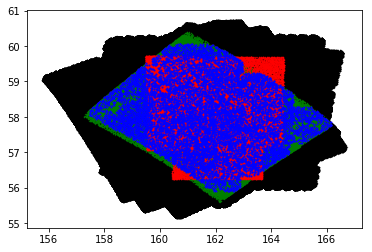

In [17]:
x = help_masterlist['ra']
y = help_masterlist['dec']
plt.scatter(x,y,s=0.1,c='black')

mips_mask = (help_masterlist['flag_optnir_det']>=5)
x = help_masterlist['ra'][mips_mask]
y = help_masterlist['dec'][mips_mask]
plt.scatter(x,y,s=0.1,c='green')

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1,c='red')


plt.scatter(ras,decs,s=1,c='blue')

plt.show()

In [48]:
Table.write(prior_cat,'data/data_release/xidplus_prior_cat_rerun_ldust.fits',overwrite=True)

## Create the prior for the MIPS rerun

In [10]:
mips_mask = (help_masterlist['flag_optnir_det']>=5)

prior_cat = help_masterlist[mips_mask]
print('number of help prior sources is: {}'.format(len(prior_cat)))

number of help prior sources is: 563112


In [11]:
MIPS_lower=np.full(len(prior_cat),0.0)
MIPS_upper=np.full(len(prior_cat),1E5)
for i in range(len(prior_cat)):
    if np.isnan(prior_cat['f_irac_i4'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i4'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i4'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i3'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i3'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i3'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i2'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i2'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i2'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i1'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i1'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i1'][i]*500.0
        
mips_lower_col = Column(MIPS_lower,name='MIPS_lower')
mips_upper_col = Column(MIPS_upper,name='MIPS_upper')
prior_cat.add_columns([mips_lower_col,mips_upper_col])

In [12]:
swire_mask = best_irac(lofar['ch1_swire_fluxerr_corr'],lofar['ch1_servs_fluxerr_corr'])
i1_f = np.zeros(len(ras))
i1_f[swire_mask] = lofar['ch1_swire_flux_corr'][swire_mask]
i1_f[~swire_mask] = lofar['ch1_servs_flux_corr'][~swire_mask]

swire_mask = best_irac(lofar['ch2_swire_fluxerr_corr'],lofar['ch2_servs_fluxerr_corr'])
i2_f = np.zeros(len(ras))
i2_f[swire_mask] = lofar['ch2_swire_flux_corr'][swire_mask]
i2_f[~swire_mask] = lofar['ch2_servs_flux_corr'][~swire_mask]

i3_f = lofar['ch3_swire_flux_corr']

i4_f = lofar['ch4_swire_flux_corr']

In [13]:
cra = Column(ras,name='ra')
cdec = Column(decs,name='dec')
cids = Column(ids,name='help_id')
cdet = Column(np.zeros(len(ras))-99,name='flag_optnir_det')
ci1 = Column(i1_f,name='f_irac_i1')
ci2 = Column(i2_f,name='f_irac_i2')
ci3 = Column(i3_f,name='f_irac_i3')
ci4 = Column(i4_f,name='f_irac_i4')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,ci1,ci2,ci3,ci4])

In [14]:
MIPS_lower=np.full(len(lofar_prior),0.0)
MIPS_upper=np.full(len(lofar_prior),1E5)
for i in range(len(lofar_prior)):
    if np.isnan(lofar_prior['f_irac_i4'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i4'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i4'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i3'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i3'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i3'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i2'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i2'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i2'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i1'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i1'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i1'][i]*500.0
        
mips_lower_col = Column(MIPS_lower,name='MIPS_lower')
mips_upper_col = Column(MIPS_upper,name='MIPS_upper')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,ci1,ci2,ci3,ci4,mips_lower_col,mips_upper_col])

In [15]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

574869

In [16]:
prior_cat[0]

ra,dec,help_id,flag_optnir_det,f_irac_i1,f_irac_i2,f_irac_i3,f_irac_i4,f_mips_24,f_pacs_green,f_spire_250,MIPS_lower,MIPS_upper
deg,deg,,,,,uJy,uJy,uJy,mJy,mJy,,
float64,float64,bytes33,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64
157.2796582227025,57.99707349485325,HELP_J102907.118+575949.465,5.0,190.24,nan,174.37,nan,306.02975,60320.906,30009.219,0.34874,87185.0


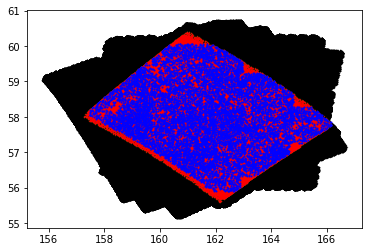

In [17]:
x = help_masterlist['ra']
y = help_masterlist['dec']
plt.scatter(x,y,s=0.1,c='black')

mips_mask = (help_masterlist['flag_optnir_det']>=5)
x = help_masterlist['ra'][mips_mask]
y = help_masterlist['dec'][mips_mask]
plt.scatter(x,y,s=0.1,c='green')

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1,c='red')


plt.scatter(ras,decs,s=1,c='blue')

plt.show()

In [20]:
#Table.write(prior_cat,'data/data_release/xidplus_prior_cat_MIPS_rerun.fits',overwrite=True)

from astropy.io import registry
from astropy.table.info import serialize_method_as

with serialize_method_as(prior_cat, None):
            registry.write(prior_cat,'data/data_release/xidplus_prior_cat_MIPS_rerun.fits',overwrite=True,format='fits')

<class 'astropy.table.table.Table'>
fits
